In [2]:
import sys
sys.path.append("/home/149/ab8992/tasman-tides/")
import xarray as xr
import ttidelib as tt
import scipy
import cmocean
import os
from pathlib import Path
cmap = cmocean.cm.dense_r
import matplotlib
import matplotlib.pyplot as plt
earth_cmap = matplotlib.colormaps["gist_earth"]
from datetime import timedelta
import warnings
warnings.simplefilter("ignore")
# import filtering
import numpy as np
import dask
dask.config.set({'logging.distributed': 'error'})
from dask.distributed import Client,default_client
import xrft
import matplotlib.gridspec as gridspec

client = tt.startdask(nthreads=1,n_workers = 52)

client

<Client: 'tcp://127.0.0.1:44663' processes=52 threads=52, memory=416.00 GiB>


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 52
Total threads: 52,Total memory: 416.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44663,Workers: 52
Dashboard: /proxy/8787/status,Total threads: 52
Started: Just now,Total memory: 416.00 GiB
Comm: tcp://127.0.0.1:36457,Total threads: 1
Dashboard: /proxy/35281/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:33149,


# EF reflection plan:

For this dataset, we'll have 3 main figures 

1. 2x3 grid of incoming, reflected mode1, mode 2, mode 3+ energy for full-40th. Include a supplementary figure or two showing results from other resolutions - **do this later**. Show our contour integral on this plot, and show topo underneath.
2. Timeseries of full-40 in/out energy flux over the contour for 3 modes. Include the cross terms as the errorbar. Print out the rest of the data as a table, including in/out for 3 modes, + total crossterm & total st.dev
3. Show dissipation anomalies for 10,20,40

In [3]:

data = {}
for expt in ["full-10","beamless-10","smooth-10","beamless-20","smooth-20","full-20","full-40","beamless-40","smooth-40"]:
# for expt in ["smooth-40"]:
    path = Path(f"/scratch/nm03/ab8992/april-manytimes") / expt
    bathy = xr.open_dataset(f"/g/data/nm03/ab8992/outputs/{expt}/bathy_transect.nc").sel(yb = slice(-120,120))
    times = os.listdir(path)
    data[expt] = xr.merge(
    [
        xr.open_dataset(path / times[0] / "EF_alongbeam.nc",decode_times= False).rename({"EF":"EF_alongbeam"}).mean("time").load(),
        xr.open_dataset(path / times[0] / "EF_acrossbeam.nc",decode_times= False).rename({"EF":"EF_acrossbeam"}).mean("time").load(),
        xr.open_dataset(path / times[0] / "EF_alongbeam_forward.nc",decode_times= False),
        xr.open_dataset(path / times[0] / "EF_alongbeam_backward.nc",decode_times= False),
        xr.open_dataset(path / times[0] / "EF_alongbeam_xterm.nc",decode_times= False),
        xr.open_dataset(path / times[0] / "EF_acrossbeam_forward.nc",decode_times= False),
        xr.open_dataset(path / times[0] / "EF_acrossbeam_backward.nc",decode_times= False),
        xr.open_dataset(path / times[0] / "EF_acrossbeam_xterm.nc",decode_times= False),
        xr.open_dataset(path / times[0] / "filtered_dissipation.nc",decode_times= False),
        bathy.rename({"depth":"bathy"}) * -1
     ]
).sel(xb = slice(0,1200)).expand_dims({"time":[times[0].split("t0-")[1]]})
    for i in range(1,len(times)):

        try:
            data[expt] = xr.concat(
            [
                data[expt],
                xr.merge(
                    [
                        xr.open_dataset(path / times[i] / "EF_alongbeam.nc",decode_times= False).rename({"EF":"EF_alongbeam"}).mean("time").load(),
                        xr.open_dataset(path / times[i] / "EF_acrossbeam.nc",decode_times= False).rename({"EF":"EF_acrossbeam"}).mean("time").load(),
                        xr.open_dataset(path / times[i] / "EF_alongbeam_forward.nc",decode_times= False),
                        xr.open_dataset(path / times[i] / "EF_alongbeam_backward.nc",decode_times= False),
                        xr.open_dataset(path / times[i] / "EF_alongbeam_xterm.nc",decode_times= False),
                        xr.open_dataset(path / times[i] / "EF_acrossbeam_forward.nc",decode_times= False),
                        xr.open_dataset(path / times[i] / "EF_acrossbeam_backward.nc",decode_times= False),
                        xr.open_dataset(path / times[i] / "EF_acrossbeam_xterm.nc",decode_times= False),
                        xr.open_dataset(path / times[i] / "filtered_dissipation.nc",decode_times= False),
                        bathy.rename({"depth":"bathy"}) * -1
                    ]
                ).sel(xb = slice(0,1200)).expand_dims({"time":[times[i].split("t0-")[1]]}),
            ],
            dim = "time"
            )
        except Exception as e:
            print(f"Error processing time {times[i]} for experiment {expt}: {e}")

    # data[expt] = data[expt].mean("time")


Error processing time t0-22200 for experiment smooth-40: [Errno 2] No such file or directory: '/scratch/nm03/ab8992/april-manytimes/smooth-40/t0-22200/EF_alongbeam.nc'
Error processing time t0-5760 for experiment smooth-40: [Errno 2] No such file or directory: '/scratch/nm03/ab8992/april-manytimes/smooth-40/t0-5760/EF_alongbeam_forward.nc'


In [4]:
def contour_mask_singleline(xs,ys,data):
    """
    Returns umask,vmask
    """
    dx = (data.yb[1] - data.yb[0]).values
    if xs[0] == xs[1]: # HANDLE VERTICAL LINE
        return xr.where(
            (np.abs(data.xb - xs[0]) < dx) *
            (data.yb > ys[0]) * 
            (data.yb < ys[1])            
            ,1,0
        ).fillna(0), data * 0
    if ys[0] == ys[1]: # HANDLE HORIZONTAL LINE
        return data * 0,xr.where(
            (np.abs(data.yb - ys[0]) < dx) *
            (data.xb > xs[0]) * 
            (data.xb < xs[1])
            ,1,0
        ).fillna(0)
    
    ## Deal with an angled line
    m = (ys[1] - ys[0]) / (xs[1] - xs[0])
    c = ys[0] - m * xs[0]

    ## V mask first. So, we need unique points in x
    x_points = np.arange(xs[0],xs[1],dx)
    y_points = m * x_points + c
    # y_points = np.round(y_points,1)
    x_points = np.round(x_points,0)
    vmask = xr.where(
        (np.abs(data.xb - x_points[0]- 1e-5)  <= dx/2) *
        (np.abs(data.yb - y_points[0]- 1e-5)  <= dx/2)
        ,1,0
        )
    for i in range(1,len(x_points)):
        vmask += xr.where(
            (np.abs(data.xb - x_points[i] - 1e-5)  <= dx/2) *
            (np.abs(data.yb - y_points[i] - 1e-5)  <= dx/2)
            ,1,0
            )
    ## U mask second. So, we need unique points in y
    y_points = np.arange(np.min(ys),np.max(ys),dx)
    x_points = (y_points - c) / m
    umask = xr.where(
        (np.abs(data.xb - x_points[0]- 1e-5)  <= dx/2) *
        (np.abs(data.yb - y_points[0]- 1e-5)  <= dx/2)
        ,1,0
        )
    for i in range(1,len(x_points)):
        umask += xr.where(
            (np.abs(data.xb - x_points[i] - 1e-5)  <= dx/2) *
            (np.abs(data.yb - y_points[i] - 1e-5)  <= dx/2)
            ,1,0
            )

    return umask,vmask

def contour_mask_compound(xs,ys,data):
    umask,vmask = contour_mask_singleline(xs[0],ys[0],data)
    length = np.sqrt((xs[0][1] - xs[0][0])**2 + (ys[0][1] - ys[0][0])**2) * 1000
    for i in range(1,len(xs)):
        u,v = contour_mask_singleline(xs[i],ys[i],data)
        umask += u
        vmask += v
        length += np.sqrt((xs[i][1] - xs[i][0])**2 + (ys[i][1] - ys[i][0])**2) * 1000

    return xr.merge(
        [xr.where(umask == 0,0,1).rename("umask") , xr.where(vmask == 0,0,1).rename("vmask"),xr.DataArray(length).rename("length")])

def contour_integral(xs,ys,alongbeam,acrossbeam):
    """
    Pass x and y coords of straight line. Need to pre-multiply data to get orientation to line 
    correct as function just integrates along the line. If line is parallel to an axis, just 
    pre multiply alongbeam or acrossbeam by 0 to ensure that we don't integrate over empty dimension.
    """
    if type(xs[0]) == list:
        mask = contour_mask_compound(xs,ys,alongbeam)
        umask = mask["umask"]
        vmask = mask["vmask"]
        length = mask["length"]

    else:
        umask,vmask = contour_mask_singleline(xs,ys,alongbeam)
        length = np.sqrt((xs[1] - xs[0])**2 + (ys[1] - ys[0])**2) * 1000

    out = (umask * alongbeam).sum("xb").integrate("yb")
    out += (vmask * acrossbeam).sum("yb").integrate("xb")
    out = xr.Dataset({"energy":out,"length":length})
    out["energy"].attrs["Units"] = "kW"
    out["energy"].attrs["length"] = "m"
    return out # Convert km -> m

## PLOT FOR PAPER: EF quiver filtered near shelf

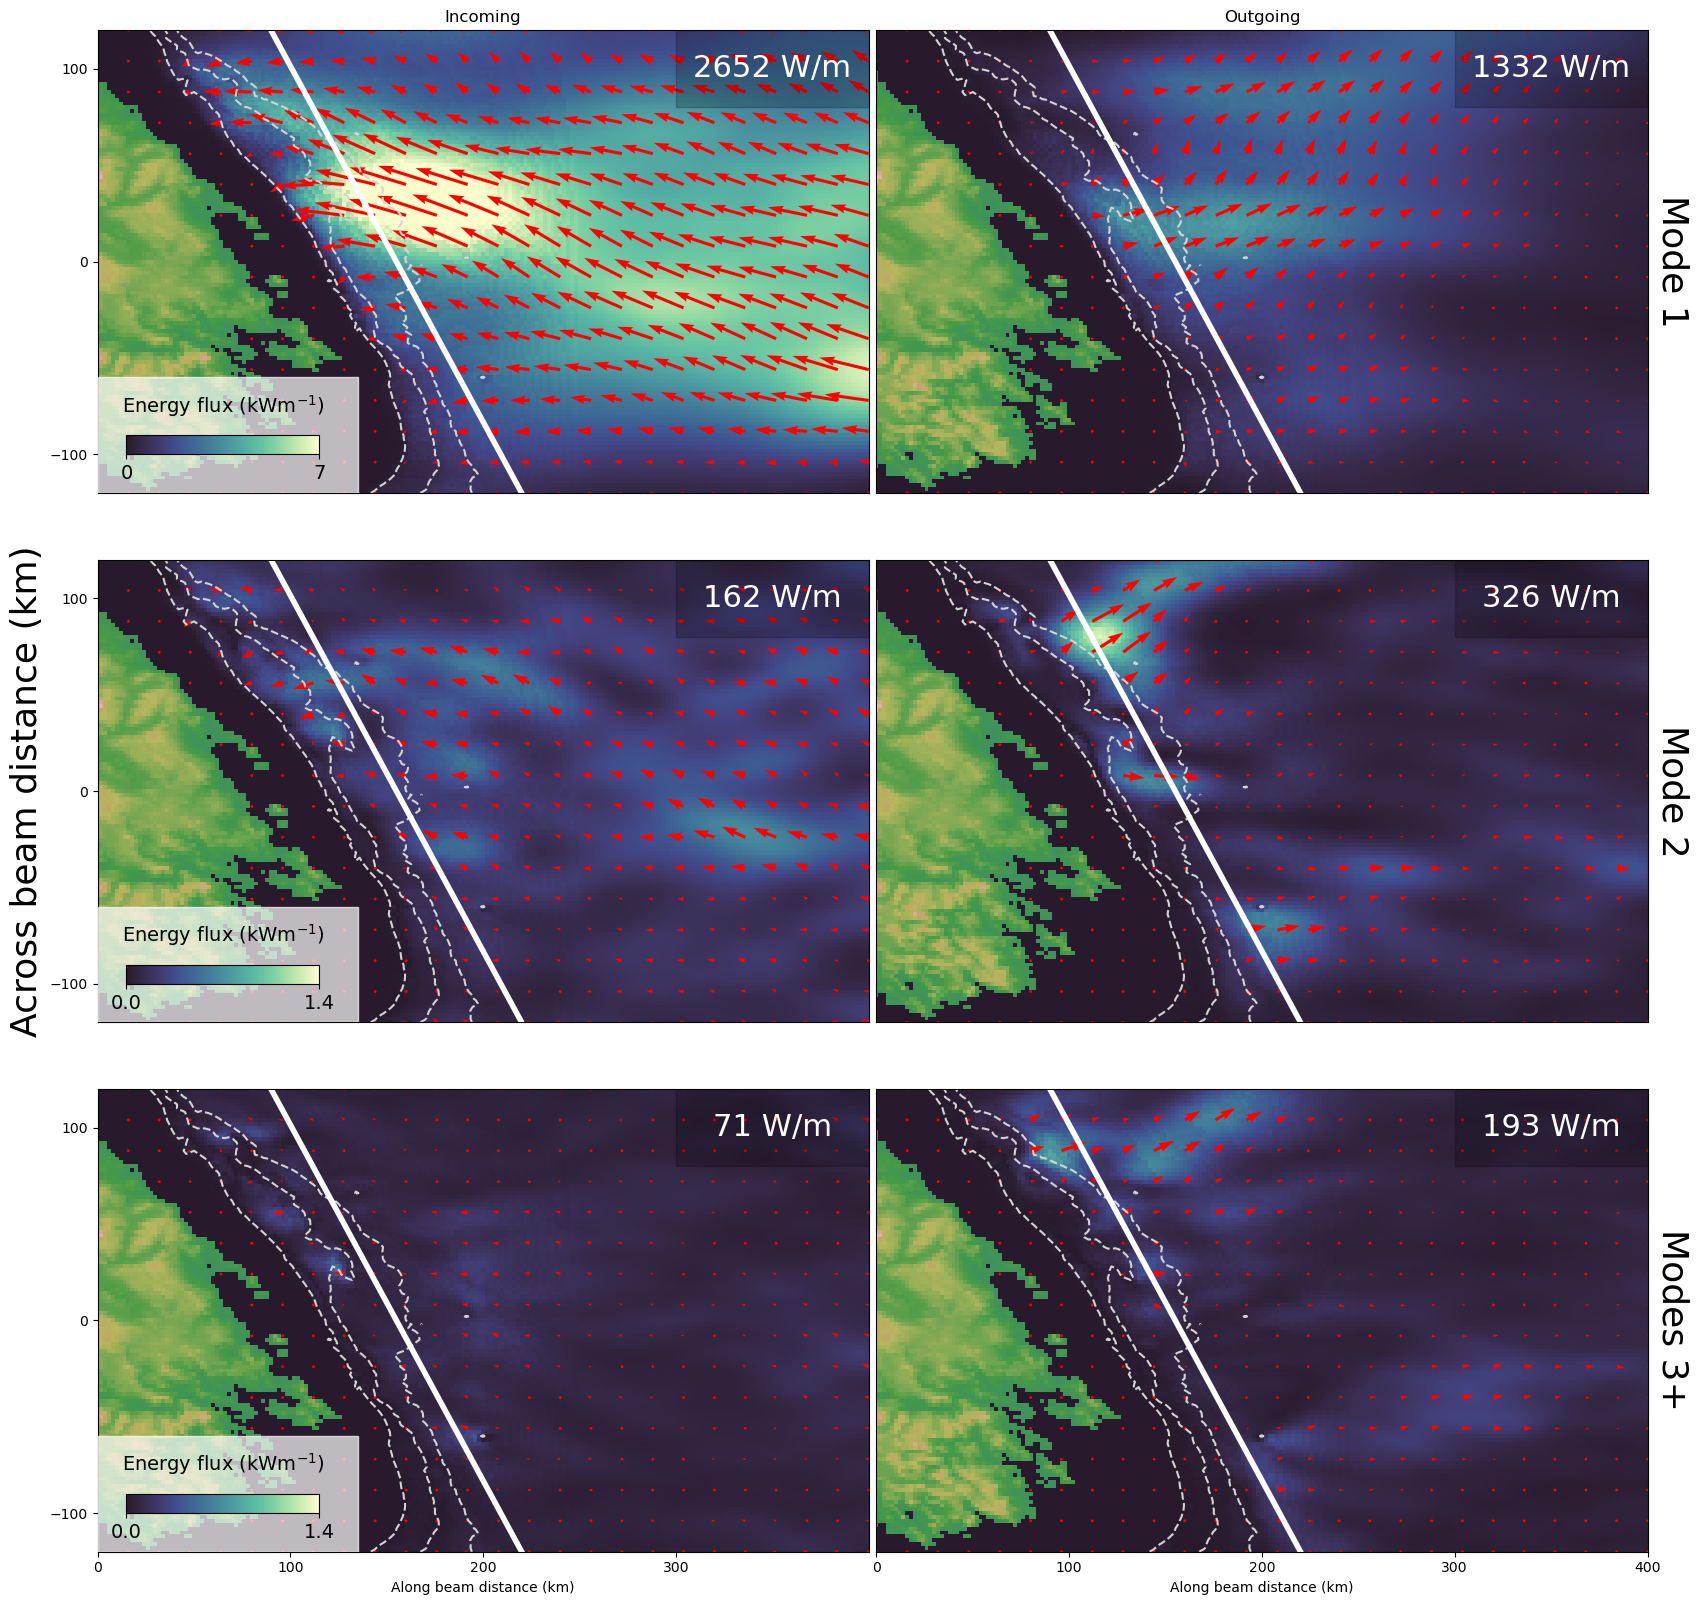

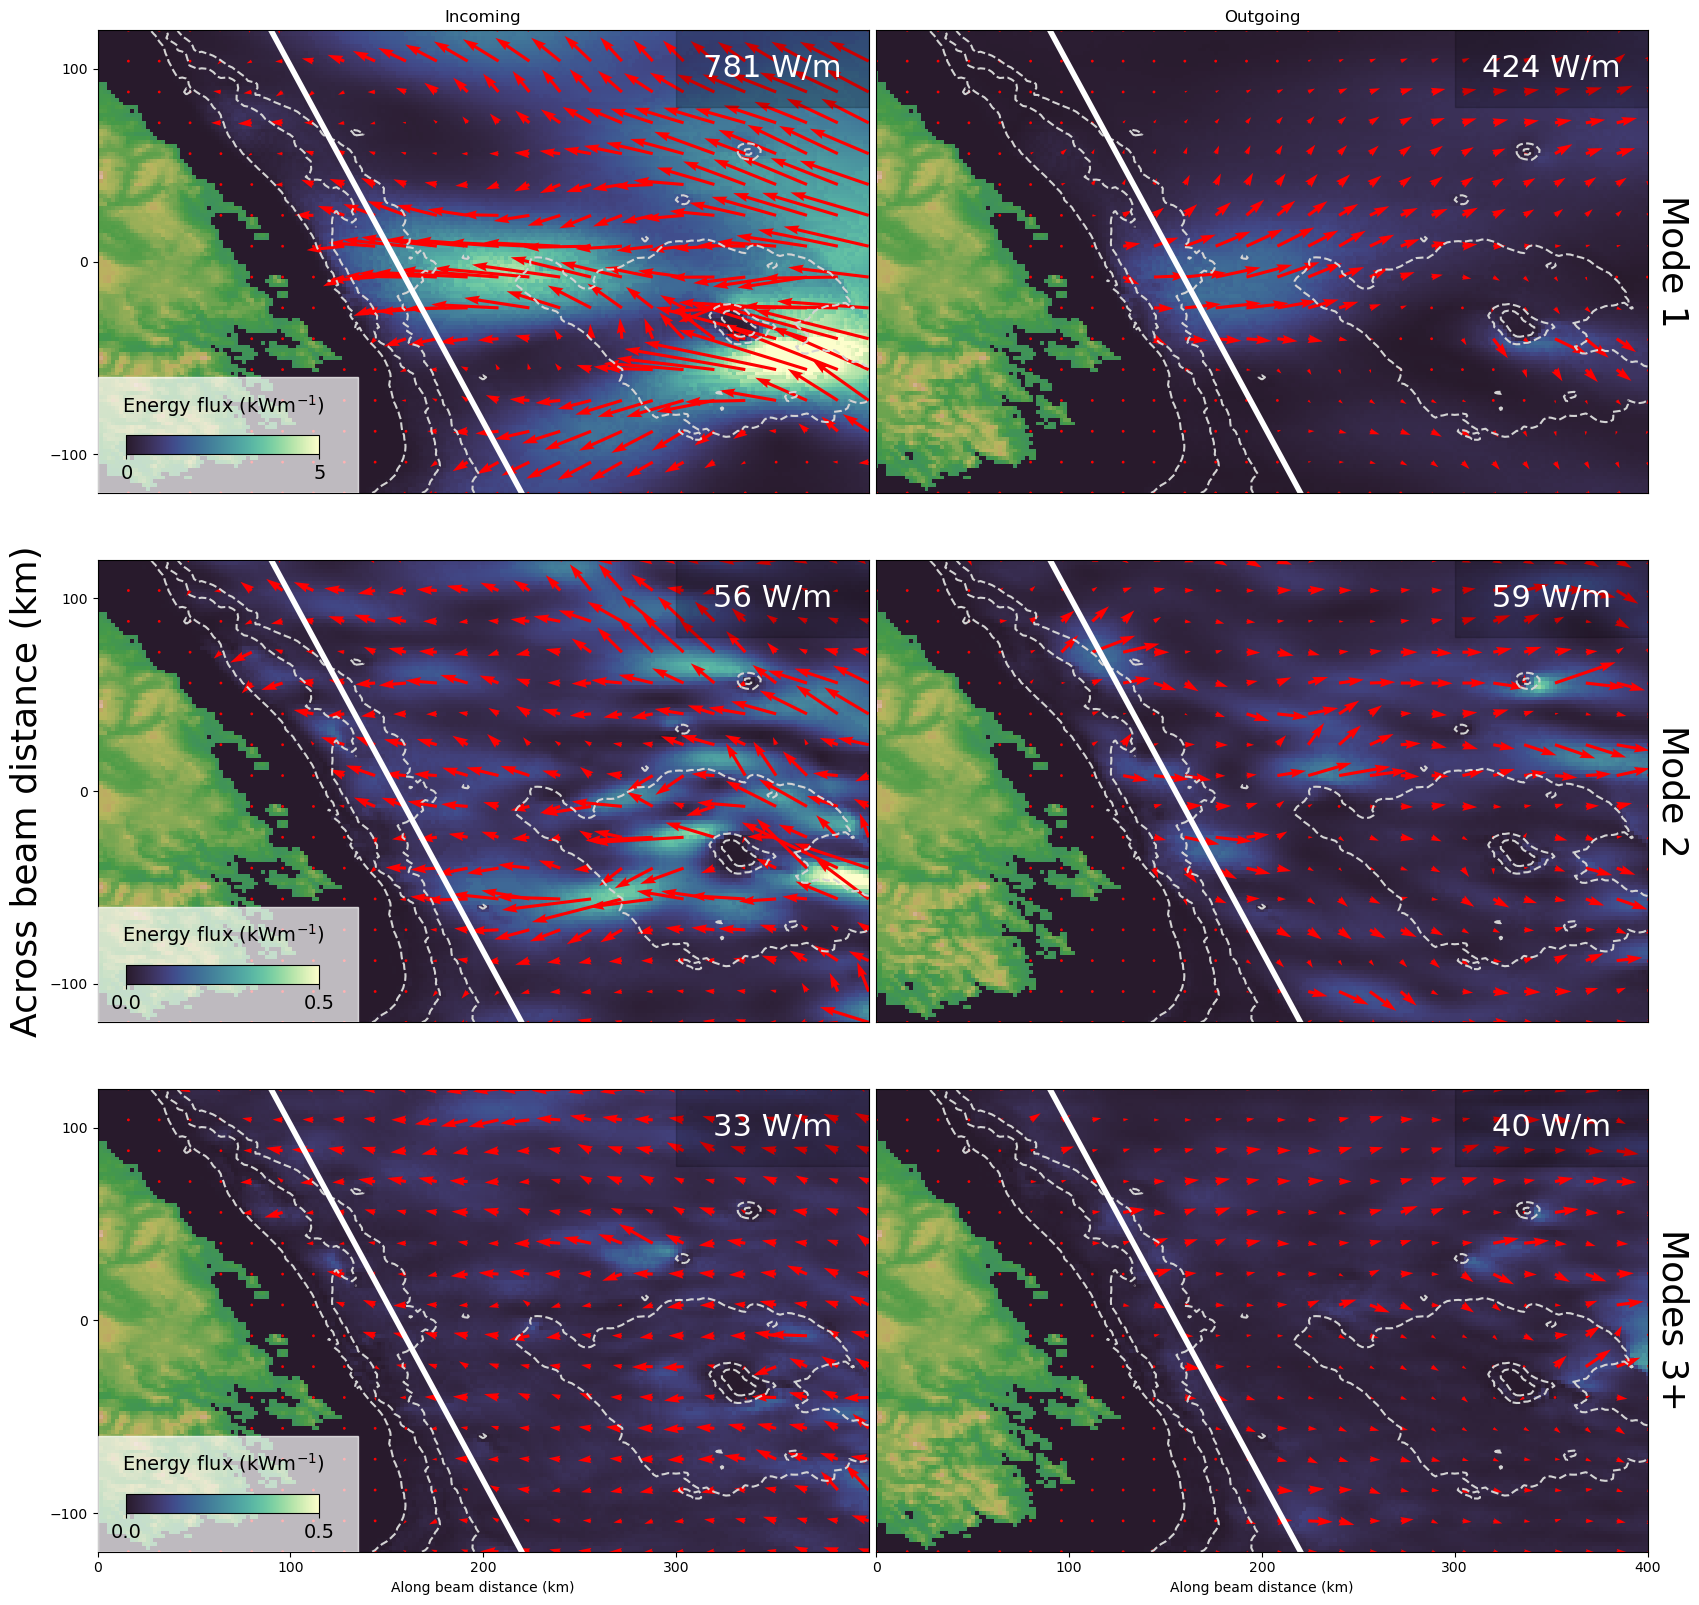

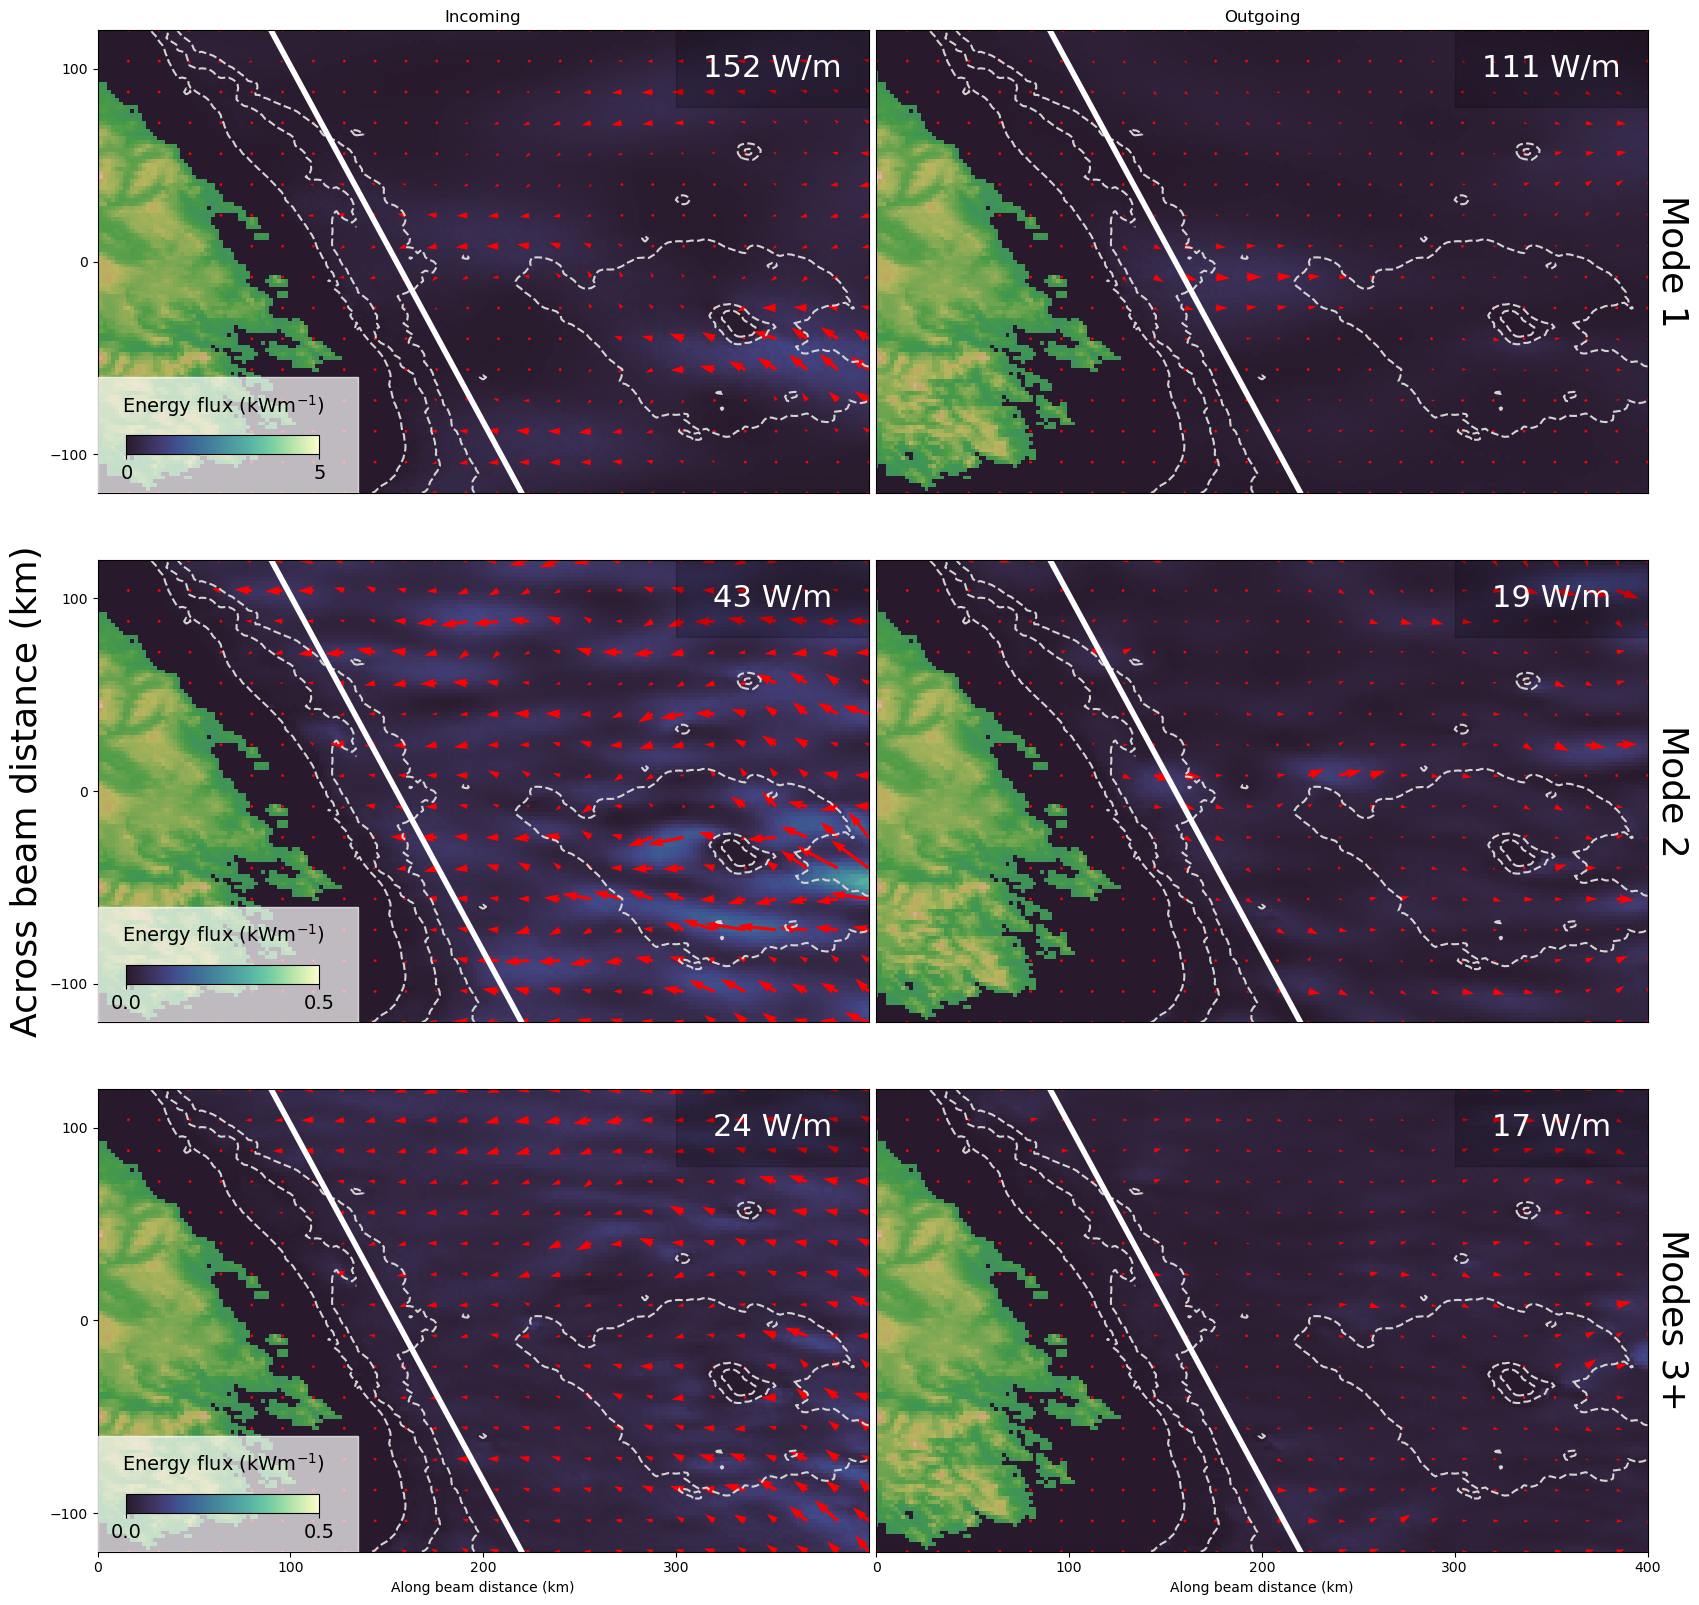

In [73]:
## Define EF integrating, masking and plotting functions
def plot_KE_quiver(alongbeam,acrossbeam,ax,mode = 0,xlim = slice(0,250),ylim = slice(-80,80),arrow_scale = 3000,mag_scale = 3000,mod_scale = 1):
    # expt = "full-20"
    arrow_scale *= mod_scale
    mag_scale *= mod_scale
    alongbeam = alongbeam.sel(xb = xlim,yb = ylim).isel(mode = mode)
    acrossbeam = acrossbeam.sel(xb = xlim,yb = ylim).isel(mode = mode)




    if "mode" in alongbeam.dims:
        alongbeam = alongbeam.sum("mode")
        acrossbeam = acrossbeam.sum("mode")


    integral = contour_integral(xs_reflect,ys_reflect,alongbeam,acrossbeam)
    total = np.abs(integral.energy.values / integral.length.values)
    # print(total" kW/m average")

    # np.sqrt(acrossbeam**2 + alongbeam**2).sum("mode").plot(ax = ax)
    yspacing = 2
    xspacing = 2
    if "20" in expt:
        yspacing,xspacing = yspacing * 2, xspacing * 2
    elif "40" in expt:
        yspacing,xspacing = yspacing * 4, xspacing * 4
    _yb = acrossbeam.yb[::yspacing]
    _xb = acrossbeam.xb[::xspacing]
    _along = (alongbeam )[::yspacing,::xspacing]
    _across = (acrossbeam)[::yspacing,::xspacing]

    # print(magnitude)
    mag = np.sqrt(alongbeam**2 + acrossbeam**2)
    mag.plot(ax = ax,add_colorbar = False,cmap = cmocean.cm.deep_r,vmax = mag_scale)

    ax.quiver(_xb, _yb, _along, _across, color="red", scale=arrow_scale,scale_units = "width",width = 0.004)
    tt.plot_topo(ax,xr.open_dataset(f"/g/data/nm03/ab8992/outputs/{expt}/bathy_transect.nc").depth * -1)

    ax.set_ylim(-120,120)
    ax.set_xlim(0,1200)
    ax.set_xlabel("")
    ax.set_ylabel("")

    ## Add patch and print the total integrated flux on it
    patch = ax.add_patch(matplotlib.patches.Rectangle((300, 80), 100, 40, color='black', alpha=0.2))
    
    ax.annotate(
        f"{total * 1000:.0f} W/m",
        xy=(350, 100),  # Position of the text
        xycoords='data',  # Use data coordinates
        fontsize=22,
        color="white",
        ha='center',  # Horizontal alignment
        va='center',  # Vertical alignment
    )

for expt in ["smooth-40","full-40","beamless-40"]:
    #!OLD LINE
    offset = 28
    xs_reflect, ys_reflect = [[90 + offset, 190 + offset],[190 + offset, 230 + offset]], [[110, -20],[-20, -110]]

    #! NEW LINE
    offset = 10
    xs_reflect, ys_reflect = [[80 + offset, 210 + offset]],[ [120, -120]]
    ymax = 100

    ## Plot an example domain to show area

    xmax = 400
    # fig,ax = plt.subplots(3,2,figsize=(20,20))
    fig = plt.figure(figsize = (20,20))
    gs = gridspec.GridSpec(3, 2, width_ratios=[1, 1], height_ratios=[1, 1, 1],hspace = 0.1,wspace = 0.01)

    ax = [fig.add_subplot(gs[i,j]) for i in range(3) for j in range(2)]
    ax = np.array(ax).reshape(3,2)

    toplot = data[expt].mean("time")
    # toplot = data[expt].isel(time = 1)

    for a in ax.flatten():
        toplot.sel(xb = slice(0,xmax)).bathy.plot(vmax = 0, vmin = -4000, cmap = cmocean.cm.deep_r,ax = a,add_colorbar = False)
        toplot.sel(xb=slice(0, xmax)).bathy.plot.contour(levels=[-1000,-2000,-3000],ax = a,colors = ["lightgrey","lightgrey","lightgrey"],linestyles = "dashed",lineweights = 2)

    arrow_scales = {"smooth-40": 100000,"full-40": 30000,"beamless-40": 30000}
    mag_scales = {"smooth-40": 7000,"full-40": 5000,"beamless-40": 5000}
    mod_scales = {"smooth-40": [1,0.2,0.2],"full-40": [1,0.1,0.1],"beamless-40": [1,0.1,0.1]}

    arrow_scale = arrow_scales[expt]
    mag_scale = mag_scales[expt]
    mod_scale = mod_scales[expt]


    plot_KE_quiver(toplot.EF_alongbeam_forward,toplot.EF_acrossbeam_forward,ax[0,0],mode = 0,xlim = slice(0,xmax),ylim = slice(None,None),arrow_scale = arrow_scale,mag_scale = mag_scale)
    plot_KE_quiver(toplot.EF_alongbeam_forward,toplot.EF_acrossbeam_forward,ax[1,0],mode = 1,xlim = slice(0,xmax),ylim = slice(None,None),arrow_scale = arrow_scale,mag_scale = mag_scale,mod_scale = mod_scale[1])
    plot_KE_quiver(toplot.EF_alongbeam_forward,toplot.EF_acrossbeam_forward,ax[2,0],mode = slice(2,None),xlim = slice(0,xmax),ylim = slice(None,None),arrow_scale = arrow_scale,mag_scale = mag_scale,mod_scale = mod_scale[2])
    plot_KE_quiver(toplot.EF_alongbeam_backward,toplot.EF_acrossbeam_backward,ax[0,1],mode = 0,xlim = slice(0,xmax),ylim = slice(None,None),arrow_scale = arrow_scale,mag_scale = mag_scale)
    plot_KE_quiver(toplot.EF_alongbeam_backward,toplot.EF_acrossbeam_backward,ax[1,1],mode = 1,xlim = slice(0,xmax),ylim = slice(None,None),arrow_scale = arrow_scale,mag_scale = mag_scale,mod_scale = mod_scale[1])
    plot_KE_quiver(toplot.EF_alongbeam_backward,toplot.EF_acrossbeam_backward,ax[2,1],mode = slice(2,None),xlim = slice(0,xmax),ylim = slice(None,None),arrow_scale = arrow_scale,mag_scale = mag_scale,mod_scale = mod_scale[2])


    for i,a in enumerate(ax.flatten()):
        for x,y in zip(xs_reflect,ys_reflect):
            a.plot([x[0],x[1]],[y[0],y[1]],color = "white",linewidth = 4)
        a.set_aspect('equal')
        a.set_xlabel("")
        a.set_ylabel("")
        a.set_title("")
        a.set_xticks([])
        a.set_yticks([])
        a.set_xlim(0,xmax)

    # Incoming: -183.1 -13.8 kW/m
    # Outgoing: 72.1 8.0 kW/m
    # Xterm: 21.5 -0.3 kW/m

    ax[0,0].set_title("Incoming")
    ax[0,1].set_title("Outgoing")
    ax[1,0].set_ylabel("Across beam distance (km)")
    ax[0,1].set_ylabel("Mode 1",rotation = 270,labelpad = 30)
    ax[1,1].set_ylabel("Mode 2",rotation = 270,labelpad = 30)
    ax[2,1].set_ylabel("Modes 3+",rotation = 270,labelpad = 30)
    for i in range(3):
        ax[i,1].yaxis.set_label_position("right")  # Set the label position to the rightax[i,1].tick_params(axis='y', labelsize=22)  # Set font size for y-axis labels
        ax[i,0].set_yticks([-100,0,100])
        ax[i,1].yaxis.label.set_size(26)  # Set font size for y-axis labels
        ax[i,0].yaxis.label.set_size(26)  # Set font size for y-axis labels

    ax[2,0].set_xlabel("Along beam distance (km)")
    ax[2,1].set_xlabel("Along beam distance (km)")
    ax[2,0].set_xticks([0,100,200,300])
    ax[2,1].set_xticks([0,100,200,300,400])

    umax = 1
    efmax = 1
    for i in range(3):
        scale = mag_scale * mod_scale[i] / 1000
        patch = ax[i,0].add_patch(matplotlib.patches.Rectangle((0, -120), 135, 60, color='white', alpha=0.7))
        cax1 = ax[i,0].inset_axes([15, -100, 100, 10],transform=ax[i,0].transData)  # Adjust size and location
        patch.set_zorder(9)
        cax1.set_zorder(10)  # Bring the patch to the front
        cbar = plt.colorbar(
            plt.cm.ScalarMappable(cmap=cmocean.cm.deep_r, norm=plt.Normalize(vmin=0, vmax=scale)),
            cax=cax1,
            orientation='horizontal',
            location="bottom",
            label=r"Energy flux (kWm$^{-1}$)",
        )
        cbar.ax.xaxis.set_label_coords(0.5, 3.2)  # Adjust the title position to be higher
        cbar.set_ticks([0,scale])
        cax1.tick_params(labelsize=14, color="black", labelcolor="black")  # Set font size and color for colorbar ticks
        cax1.xaxis.label.set_size(14)  # Set font size for colorbar label
        cax1.xaxis.label.set_color("black")  # Set label color to black


        efmax = 50
        umax = 0.2
